In [94]:
# Library Imports
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from tqdm import tqdm
from sklearn import linear_model
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pgeocode     # Postal Code GeoDistance
import pickle

from eBayML_Functions import *

In [3]:
# Setup File Names
method = 'KM10_Linear'
rev = 3
linear_model_filename = 'Models/' + method + '_R' + str(rev)
dataframe_filename = 'Features' + method + '_R' + str(rev) + '.pkl'
km_model_filename = 'Models/' + method + '_R' + str(rev) + 'KMeans.sav'


In [ ]:
# Import data
df = pd.read_csv('Data/eBay_ML_Challenge_Dataset_2021_train.tsv', sep='\t', header=0)
df = df[800000:900000]
print('Loaded raw data\nSample(n): {}\nColumns(m): {}'.format(df.shape[0],df.shape[1]))

In [17]:
'''
Debug Code
'''
# print(df.columns)
# df.nunique(axis=0)
# df.package_size.value_counts()
df.shape

(100000, 19)

In [9]:
df_Feat = feature_extraction(df)
# df_Feat.to_pickle(dataframe_filename)
df_Feat = df_Feat.fillna(0)

/Users/sunaybhat/miniconda3/envs/py36_ML/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 100000/100000 [20:25<00:00, 81.61it/s]


In [12]:
df_Feat_Full = pd.read_pickle('Features/Full_1.pkl')

100%|██████████| 20/20 [05:14<00:00, 15.73s/it]


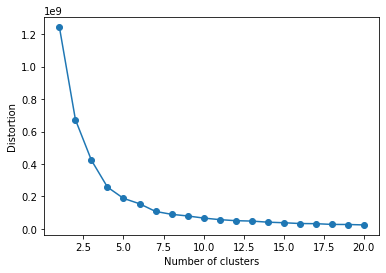

In [7]:
# calculate distortion for a range of number of cluster
distortions = []
for i in tqdm(range(1, 21)):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(df_Feat.values)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 21), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [10]:
# Kmeans
NUM_CLUSTERS = 10
km = KMeans(
    n_clusters=NUM_CLUSTERS, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)

y_km = km.fit_predict(df_Feat.values)
pickle.dump(km, open(km_model_filename, 'wb'))

In [11]:
values, counts = np.unique(y_km, return_counts=True)
counts

array([   107,  12676,   9080, 109461,   8892,   9228,  10351,  13805,
        13156,  13244])

In [28]:
linear_models = list()

for iClust in tqdm(range(NUM_CLUSTERS)):
    df_Clust = df_Feat[y_km == iClust]
    X = df_Clust.values[:,0:-1]
    y = df_Clust.values[:,-1]
    print('Training {:.2f} examples for cluster {}'.format(len(y),iClust))

    linear_models.append(linear_model.LinearRegression(normalize=True))
    linear_models[iClust].fit(X,y) 
    pickle.dump(linear_models[iClust], open(model_filename + str(iClust) + '.sav', 'wb'))

100%|██████████| 10/10 [00:00<00:00, 53.81it/s]

Training 107.00 examples for cluster 0
Training 12676.00 examples for cluster 1
Training 9080.00 examples for cluster 2
Training 109461.00 examples for cluster 3
Training 8892.00 examples for cluster 4
Training 9228.00 examples for cluster 5
Training 10351.00 examples for cluster 6
Training 13805.00 examples for cluster 7
Training 13156.00 examples for cluster 8
Training 13244.00 examples for cluster 9


In [7]:
# Load Models
linear_models = list()
for iClust in tqdm(range(6)):
    linear_models.append(pickle.load(open(model_filename + str(iClust) + '.sav', 'rb')))

df_Feat = pd.read_pickle(dataframe_filename)
df_Feat = df_Feat.fillna(0)


100%|██████████| 6/6 [00:00<00:00, 968.03it/s]


In [29]:
loss,predictions = calc_loss_clust(linear_models,df_Feat.fillna(0))

Loss is 0.42


In [40]:
# Predict 
df_quiz = pd.read_csv('Data/eBay_ML_Challenge_Dataset_2021_quiz.tsv', sep='\t', header=0)
df_Feat_Quiz = feature_extraction(df_quiz)
# df_Feat.to_pickle(dataframe_filename)
predictions = predict(linear_models,df_Feat_Quiz.fillna(0))

/Users/sunaybhat/miniconda3/envs/py36_ML/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [43]:
df_trial = df_Feat_Quiz.fillna(0)
km_predict = km.predict(df_trial.values)
predictions = np.empty(df_trial.shape[0])

for iClust in range(len(linear_models)):
    df_Clust = df_trial[km_predict == iClust]
    X = df_Clust.values[:,0:-1]
    predictions[km_predict == iClust] = linear_models[iClust].predict(X).astype(int)


In [91]:
df_out =  pd.DataFrame(np.nan, index=df_quiz.index, columns=['record identifier','predicted delivery date']).astype(str)

for iRow in tqdm(range(df_quiz.shape[0])):
        try:
                payment = datetime.strptime(df_quiz.iloc[iRow]['payment_datetime'][:16], '%Y-%m-%d %H:%M') + timedelta(hours = -int(df_quiz.iloc[iRow]['payment_datetime'][-6:-3]))
                # delivery = datetime.strptime(df.iloc[iRow]['delivery_date'],'%Y-%m-%d')
                delivery = payment + timedelta(days=predictions[iRow])
                df_out.at[iRow,'record identifier'] = df_quiz['record_number'][iRow]
                df_out.at[iRow,'predicted delivery date'] = delivery.strftime('%Y-%m-%d')
        except:
                print(iRow)
                print(df.iloc[iRow]['payment_datetime'])
                df_out.at[iRow,'record identifier'] = df_quiz['record_number'][iRow]
                

        

100%|██████████| 2500000/2500000 [18:46<00:00, 2219.29it/s]


In [92]:
df_out.to_csv('test_submit.tsv.gz', sep="\t",header=False,index=False, compression= 'gzip')